In [19]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
import scipy.stats as st
from typing import Union, Optional, Callable
Floats = Union[float, npt.NDArray[np.float_]]
import blackscholes as bs
from numba import njit
from scipy.stats import kstest

We have the equation to portpholio price under martingale measure $Q$:
$$
dV_t = rV_tdt + \sqrt{v_t} \alpha_t V_tdW_t^1\\
dv_t = \kappa (\theta - v_t)dt + \sigma \sqrt{v_t} dW_t^2\\
\alpha_t = \min \{L, \frac{\hat{\sigma}}{\sqrt{v_t}} \},
$$
where $W_t^1$ and $W_t^2$ is correlated brownian motions with $dW_t^1 dW_t^2 = ρ$.

Firstly define functions to simulate $(W_t^1, W_t^2)$:

In [10]:
@njit
def correlated_BM(t: float, nsteps: int, npaths: int, correlate_coef: float):
    dt = t / nsteps
    z1 = np.random.standard_normal(size=(nsteps, npaths)) * np.sqrt(dt)
    BM1 = np.concatenate([np.zeros((1, npaths)), np.cumsum(z1, axis=0)])

    z2 = np.random.standard_normal(size=(nsteps, npaths)) * np.sqrt(dt)
    BM2 = np.concatenate([np.zeros((1, npaths)), np.cumsum(z1, axis=0)])

    return BM1, BM1 * correlate_coef + BM2 * np.sqrt (1 - correlate_coef**2)

@njit
def correlated_standard_normal (npaths: int, correlate_coef: float):
    z1 = np.random.standard_normal(size = (npaths))
    z2 = np.random.standard_normal(size = (npaths))

    return z1, z1 * correlate_coef + z2 * np.sqrt (1 - correlate_coef**2)

Payoff function of call option:

In [11]:
@njit
def call_payoff (price: Floats, strike: float):
  return np.maximum (0, price - strike)

By Ito's formula for $\ln(V_t)$ we can write:
$$
V_t = 
V_{t_0} \exp \{ \int \limits_{t_0}^t { \Big( r - \frac{1}{2}\alpha_s^2 v_s} \Big) ds + \int \limits_{t_0}^t { \alpha_s \sqrt{v_s} dW_s^1 } \} =  
V_{t_0} \exp \{ r(t-t_0) - \frac{1}{2} \int \limits_{t_0}^t { \min \{L^2 v_s, \hat{\sigma}^2} \} ds + \int \limits_{t_0}^t { \min \{L \sqrt{v_s}, \hat{\sigma}} \} dW_s^1 \}
$$

For numerical simulation of SDE we will use:
$$
v(t_i) = v(t_{i-1}) + \kappa (\theta - v(t_{i-1}))\Delta t + \sigma \sqrt{v^+(t_{i-1})} \sqrt{\Delta t} Z^1 \\
V(t_i) = V(t_{i-1}) \exp \{ (r - \frac{\min \{L^2 \ v^+(t_{i-1}),\ \hat{\sigma}^2 \} }{2} ) \Delta t + \min \{L \sqrt{v^+(t_{i-1})},\ \hat{\sigma} \}  \sqrt{\Delta t} Z^2 \}
$$
for $i = 1, ... ,n$, where $Z^1$ and $Z^2$ are $N(0,1)$ with correlation $ρ$.

In [12]:
@njit
def simulate (correlate_coef: float, r: float, kappa: float, theta: float, sigma: float, init_variance: float, init_price: float, maturity: float, target_variance: float, max_leverage: float, npaths: int, nsteps: int):
  dt = maturity / nsteps
  price = np.full (npaths, init_price)
  variance = np.full (npaths, init_variance)

  for i in range (nsteps):
    z1, z2 = correlated_standard_normal (npaths = npaths, correlate_coef = correlate_coef)
    positive_var = np.maximum (variance, 0)
    variance, price = \
          variance + kappa * (theta - variance)*dt + sigma * np.sqrt(dt * positive_var) * z1, \
          price * np.exp ((r - 0.5 * np.minimum (max_leverage**2 * positive_var, target_variance))*dt + np.minimum (max_leverage * np.sqrt(positive_var), np.sqrt(target_variance)) * np.sqrt(dt) * z2)
  return price

Notice that we can assume r=0 because only the scaling factor of $V_t$ depends on it.

In [5]:
arr = simulate (correlate_coef = 0,
          r = 0,
          kappa = .5,
          theta = .5,
          sigma = 1,
          init_variance = .2,
          init_price = 1,
          maturity = 1,
          target_variance = .1,
          max_leverage = 2,
          npaths = 2000000, 
          nsteps = 100)


Note that if $L >> 1$:
$$
V_t \approx 
V_{t_0} \exp \{ r(t-t_0) - \frac{1}{2} \int \limits_{t_0}^t { \hat{\sigma}^2 ds } + \int \limits_{t_0}^t { \hat{\sigma} dW_s^1 } \} = 
V_{t_0} \exp \{ (r - \frac{1}{2} \hat{\sigma}^2 ) (t - t_0)  + \hat{\sigma} (W_t^1 - W_{t_0}^1) \}
$$
and if $t > t_0 >> 1: v_t \approx θ$, therefore 
$$
V_t \approx 
V_{t_0} \exp \{ r(t-t_0) - \frac{1}{2} \int \limits_{t_0}^t { \min \{L^2 θ, \hat{\sigma}^2} \} ds + \int \limits_{t_0}^t { \min \{L \sqrt{θ}, \hat{\sigma}} \} dW_s^1 \} = \\ =
V_{t_0} \exp \{ (r - \frac{1}{2} \min \{L^2 θ, \hat{\sigma}^2 \} ) (t - t_0)  + \min \{L \sqrt{θ}, \hat{\sigma} \} (W_t^1 - W_{t_0}^1) \}
$$
In both cases $V_t$ has Log-Normal distribution, so it looks logical to compare distribution of $\ln V_t$ with normal.

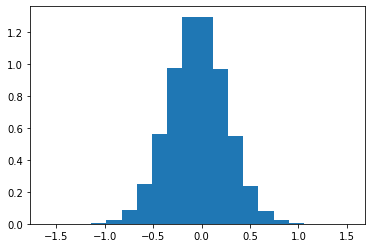

In [6]:
plt.hist(np.log(arr), bins = 20, density = True)
plt.show()

Visually the histogram really looks like a normal distribution. However, using the Kolmogorov-Smirnov test, we can verify that $\ln V_t$ is actually not normally distributed. At this moment, the presence of a minimum in SDE affects.

In [7]:
kstest ((arr - np.mean(arr))/np.std(arr), 'norm')

KstestResult(statistic=0.05898162496786752, pvalue=0.0)

We can also plot the sample option price against strike:

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


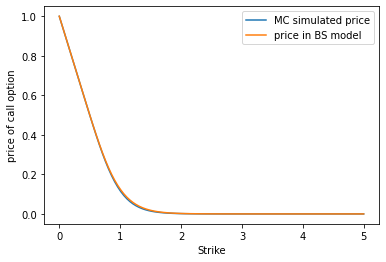

In [8]:
K = np.linspace (0, 5, 100)
prices = [np.mean (call_payoff (arr, k)) for k in K]
plt.plot (K, prices, label = 'MC simulated price')
bs_prices = bs.call_price(s = 1, 
                          sigma = np.sqrt(.1),  # sqrt(target_variance)
                          t = 1, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model')
plt.xlabel("Strike")
plt.ylabel("price of call option")
plt.legend()
plt.show()

In [9]:
a = simulate (correlate_coef = 0,
          r = 0,
          kappa = .5,
          theta = .02,
          sigma = .1,
          init_variance = .2,
          init_price = 1,
          maturity = 1,
          target_variance = .2,
          max_leverage = 2,
          npaths = 2000000, 
          nsteps = 100)

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


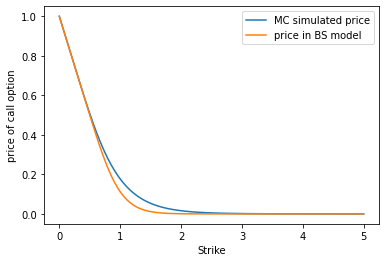

In [10]:
prices = [np.mean (call_payoff (a, k)) for k in K]
plt.plot (K, prices, label = 'MC simulated price')
bs_prices = bs.call_price(s = 1, 
                          sigma = np.sqrt(.08),  # L * sqrt(theta)
                          t = 1, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model')
plt.xlabel("Strike")
plt.ylabel("price of call option")
plt.legend()
plt.show()

In [11]:
b = simulate (correlate_coef = 0,
          r = 0,
          kappa = .5,
          theta = .02,
          sigma = .1,
          init_variance = .2,
          init_price = 1,
          maturity = 1,
          target_variance = .08,
          max_leverage = 2,
          npaths = 2000000, 
          nsteps = 100)

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


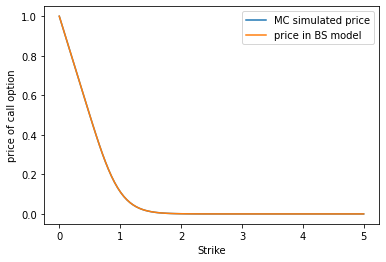

In [12]:
prices = [np.mean (call_payoff (b, k)) for k in K]
plt.plot (K, prices, label = 'MC simulated price')
bs_prices = bs.call_price(s = 1, 
                          sigma = np.sqrt(.08),  # L * sqrt(theta) == sqrt(target_variance)
                          t = 1, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model')
plt.xlabel("Strike")
plt.ylabel("price of call option")
plt.legend()
plt.show()

Now let's construct similar graphs in the case of T = 10.

In [13]:
arr_long = simulate (correlate_coef = 0,
          r = 0,
          kappa = .5,
          theta = .5,
          sigma = 1,
          init_variance = .2,
          init_price = 1,
          maturity = 10,
          target_variance = .1,
          max_leverage = 2,
          npaths = 2000000, 
          nsteps = 1000)

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


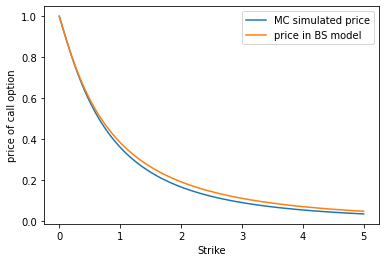

In [14]:
prices = [np.mean (call_payoff (arr_long, k)) for k in K]
plt.plot (K, prices, label = 'MC simulated price')
bs_prices = bs.call_price(s = 1, 
                          sigma = np.sqrt(.1),  # target_variance
                          t = 10, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model')
plt.xlabel("Strike")
plt.ylabel("price of call option")
plt.legend()
plt.show()

In [15]:
a_long = simulate (correlate_coef = 0,
          r = 0,
          kappa = .5,
          theta = .02,
          sigma = .1,
          init_variance = .2,
          init_price = 1,
          maturity = 10,
          target_variance = .1,
          max_leverage = 2,
          npaths = 2000000, 
          nsteps = 1000)

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


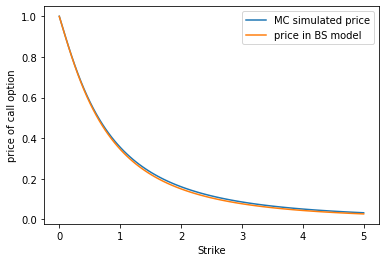

In [16]:
prices = [np.mean (call_payoff (a_long, k)) for k in K]
plt.plot (K, prices, label = 'MC simulated price')
bs_prices = bs.call_price(s = 1, 
                          sigma = np.sqrt(.08),  # L^2 * theta
                          t = 10, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model')
plt.xlabel("Strike")
plt.ylabel("price of call option")
plt.legend()
plt.show()

In [17]:
b_long = simulate (correlate_coef = 0,
          r = 0,
          kappa = .5,
          theta = .02,
          sigma = .1,
          init_variance = .2,
          init_price = 1,
          maturity = 10,
          target_variance = .08,
          max_leverage = 2,
          npaths = 2000000, 
          nsteps = 1000)

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


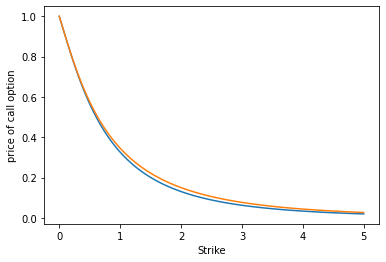

In [18]:
prices = [np.mean (call_payoff (b_long, k)) for k in K]
plt.plot (K, prices, label = 'MC simulated price')
bs_prices = bs.call_price(s = 1, 
                          sigma = np.sqrt(.08),  # L^2 * theta == target_variance
                          t = 10, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model')
plt.xlabel("Strike")
plt.ylabel("price of call option")
plt.show()

Let's find out how the price of a call option changes with an increase in the maximum leverage L.

In [19]:
L = np.linspace (1, 15, 15)
results = [ simulate (correlate_coef = 0,
          r = 0,
          kappa = .5,
          theta = .05,
          sigma = .3,
          init_variance = .2,
          init_price = 1,
          maturity = 1,
          target_variance = .3,
          max_leverage = l,
          npaths = 2000000, 
          nsteps = 100) for l in L ]

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


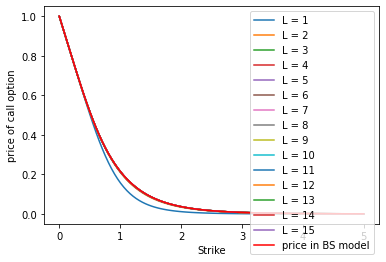

In [20]:
K = np.linspace (0, 5, 100)
for i in range(15):
  prices = [np.mean (call_payoff (results[i], k)) for k in K]
  plt.plot (K, prices, label = f"L = {int(L[i])}")
bs_prices = bs.call_price(s = 1, 
                          sigma = np.sqrt(.3),
                          t = 1, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model', color = 'r')
plt.xlabel("Strike")
plt.ylabel("price of call option")
plt.legend()
plt.show()

In [21]:
results_long = [ simulate (correlate_coef = 0,
          r = 0,
          kappa = .5,
          theta = .05,
          sigma = .3,
          init_variance = .2,
          init_price = 1,
          maturity = 10,
          target_variance = .3,
          max_leverage = l,
          npaths = 200000, 
          nsteps = 1000) for l in L ]

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


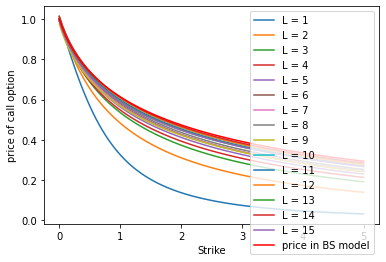

In [22]:
K = np.linspace (0, 5, 100)
for i in range(15):
  prices = [np.mean (call_payoff (results_long[i], k)) for k in K]
  plt.plot (K, prices, label = f"L = {int(L[i])}")
bs_prices = bs.call_price(s = 1, 
                          sigma = np.sqrt(.3),
                          t = 10, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model', color = 'r')
plt.xlabel("Strike")
plt.ylabel("price of call option")
plt.legend()
plt.show()

We have obtained graphs that are monotonic in L

Let's check what will change if $\rho \neq 0$.

In [23]:
Ro = np.linspace (-1, 1, 21)
res = [ simulate (correlate_coef = ro,
          r = 0,
          kappa = .5,
          theta = .05,
          sigma = .3,
          init_variance = .2,
          init_price = 1,
          maturity = 10,
          target_variance = .3,
          max_leverage = 2,
          npaths = 200000, 
          nsteps = 1000) for ro in Ro ]

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


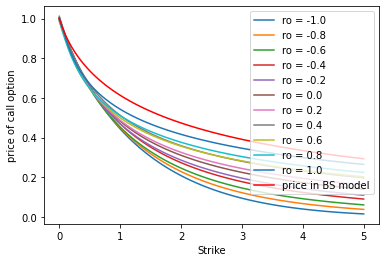

In [24]:
K = np.linspace (0, 5, 100)
for i in range(0, 21, 2):
  prices = [np.mean (call_payoff (res[i], k)) for k in K]
  plt.plot (K, prices, label = f"ro = {'%.1f' % Ro[i]}")
bs_prices = bs.call_price(s = 1, 
                          sigma = np.sqrt(.3),
                          t = 10, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model', color = 'r')
plt.xlabel("Strike")
plt.ylabel("price of call option")
plt.legend()
plt.show()

We observe increase in option price by the $\rho$. Why?

# Integral simulation


$\displaystyle A_t = \int\limits_0^t\min\lbrace L^2 \cdot \sigma^2_u,\  \hat{\sigma}^2\rbrace\,du, $

\\

$  \xi_t = A_t^{-\frac{1}{2}} \int\limits_0^t\min\lbrace L \cdot \sigma_u,\  \hat{\sigma}\rbrace \, dW_u$

$$\displaystyle\pi_0(X) = \int\limits_0^{+\infty} \pi_0^{BS}(X|\omega) dF_A(\omega), $$
where $\pi_0^{BS}(X|\omega)$ - european call option price in BS-model with volatility $\displaystyle \sigma = \sqrt{\frac{\omega}{T}}$

In [6]:
@njit
def simulate_2 (kappa: float, theta: float, sigma: float, init_variance: float, maturity: float, target_variance: float, max_leverage: float, npaths: int, nsteps: int):
  dt = maturity / nsteps
  variance = np.full (npaths, init_variance)
  integral_a  = np.full (npaths, .0)
  integral_xi = np.full (npaths, .0)

  for i in range (nsteps):
    z1 = np.random.standard_normal(size = (npaths))
    z2 = np.random.standard_normal(size = (npaths))
    positive_var = np.maximum (variance, 0)
    variance, integral_a, integral_xi = \
          variance + kappa * (theta - variance)*dt + sigma * np.sqrt(dt * positive_var) * z1, \
          integral_a  + dt * np.minimum (max_leverage**2 * positive_var, target_variance), \
          integral_xi + np.sqrt(dt) * z2 * np.minimum (max_leverage * np.sqrt(positive_var), np.sqrt(target_variance))
  integral_xi /= np.sqrt(integral_a)
  return (integral_a, integral_xi)

First consider the case $\hat{\sigma}^2 > L^2 \cdot \theta$.

In [87]:
a, xi = simulate_2 (kappa = .5,
                    theta = .02,
                    sigma = .1,
                    init_variance = .2,
                    maturity = 10,
                    target_variance = .15,
                    max_leverage = 2,
                    npaths = 2000000, 
                    nsteps = 1000)

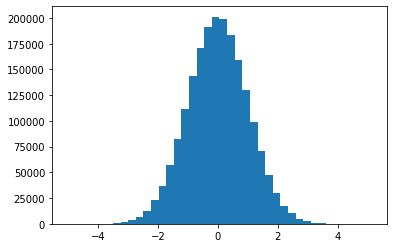

In [70]:
plt.hist(xi, bins = 40)
plt.show()

In [74]:
kstest ((xi - np.mean(xi))/np.std(xi), 'norm')

KstestResult(statistic=0.00033242111239195626, pvalue=0.9798771746910333)

We got that $\xi_t$ has a normal distribution.

In [66]:
np.unique(a, return_counts=True)

(array([0.40061611, 0.40494915, 0.41673778, ..., 1.49999995, 1.49999997,
        1.5       ]), array([   1,    1,    1, ...,    1,    1, 7339]))

In [26]:
s_0 = 1.0
T = 10
K = 1.0
r = 0

We have N positive simulations of $A_T$: $A^{(1)}, ..., A^{(N)}$, so we can approximate $\displaystyle\pi_0(X)$ in the following way:
$$
\displaystyle\pi_0(X) = \int\limits_0^{+\infty} \pi_0^{BS}(X|\omega) dF_A(\omega) \approx 
\int\limits_0^{+\infty} \pi_0^{BS}(X|\omega) d\hat{F}_A(\omega) =
\frac{1}{N} \sum\limits_{i=1}^N {\pi_0^{BS}(X|A^{(i)})},
$$
$$
\text{where } \ 
\hat{F}_A(\omega) = \frac{1}{N}  \sum\limits_{i=1}^N {I \{ A^{(i)} < \omega \}}
$$

In [24]:
def pi_0 (a, K):
  return np.mean (bs.call_price (s = s_0,
                                 sigma = np.sqrt (a / T),
                                 t = T,
                                 r = r,
                                 k = K))

In [98]:
pi_0(a, K)

0.40427492610156357

In [62]:
np.mean(call_payoff (strike = K, price = simulate (correlate_coef = 0,
                                          r = 0,
                                          kappa = .5,
                                          theta = .02,
                                          sigma = .1,
                                          init_variance = .2,
                                          init_price = 1.0,
                                          maturity = 10,
                                          target_variance = .15,
                                          max_leverage = 2,
                                          npaths = 2000000, 
                                          nsteps = 1000)))

0.40518036772264326

In [91]:
arr = simulate (correlate_coef = 0,
                r = 0,
                kappa = .5,
                theta = .02,
                sigma = .1,
                init_variance = .2,
                init_price = 1.0,
                maturity = 10,
                target_variance = .15,
                max_leverage = 2,
                npaths = 2000000, 
                nsteps = 1000)

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


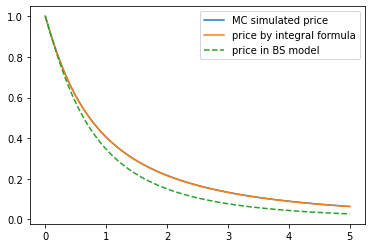

In [103]:
K = np.linspace (0, 5, 100)
mc_price = [np.mean (call_payoff (arr, k)) for k in K]
plt.plot (K, mc_price, label = 'MC simulated price')

integral_price = [pi_0 (a, k) for k in K]
plt.plot (K, integral_price, label = 'price by integral formula')

bs_prices = bs.call_price(s = 1.0, 
                          sigma = np.sqrt(.08),  # L * sqrt(theta)
                          t = 10, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model', ls = '--')
plt.legend()
plt.show()

Now let's consider the case $\hat{\sigma}^2 < L^2 \cdot \theta$.

In [104]:
a_2, xi_2 = simulate_2 (kappa = .5,
                        theta = .08,
                        sigma = .1,
                        init_variance = .2,
                        maturity = 10,
                        target_variance = .15,
                        max_leverage = 2,
                        npaths = 2000000, 
                        nsteps = 1000)
arr_2 = simulate (correlate_coef = 0,
                  r = 0,
                  kappa = .5,
                  theta = .08,
                  sigma = .1,
                  init_variance = .2,
                  init_price = 1.0,
                  maturity = 10,
                  target_variance = .15,
                  max_leverage = 2,
                  npaths = 2000000, 
                  nsteps = 1000)

In [109]:
np.unique(a_2, return_counts=True)

(array([1.14010664, 1.16431401, 1.17095977, ..., 1.5       , 1.5       ,
        1.5       ]),
 array([      1,       1,       1, ...,       1,       1, 1280055]))

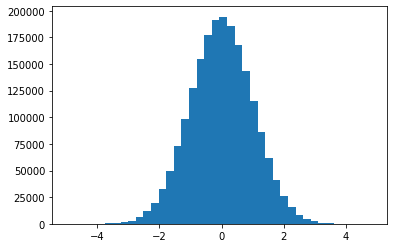

In [107]:
plt.hist(xi_2, bins = 40)
plt.show()

In [106]:
kstest ((xi_2 - np.mean(xi_2))/np.std(xi_2), 'norm')

KstestResult(statistic=0.0004986001375409943, pvalue=0.7024871306980187)

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


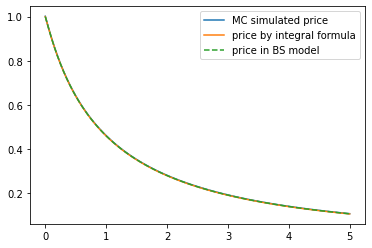

In [111]:
K = np.linspace (0, 5, 100)
mc_price = [np.mean (call_payoff (arr_2, k)) for k in K]
plt.plot (K, mc_price, label = 'MC simulated price')

integral_price = [pi_0 (a_2, k) for k in K]
plt.plot (K, integral_price, label = 'price by integral formula')

bs_prices = bs.call_price(s = 1.0, 
                          sigma = np.sqrt(.15),  # sqrt(target_variance)
                          t = 10, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model', ls = '--')
plt.legend()
plt.show()

Finally consider the case $\hat{\sigma}^2 = L^2 \cdot \theta$.

In [14]:
a_3, xi_3 = simulate_2 (kappa = .5,
                        theta = .04,
                        sigma = .1,
                        init_variance = .2,
                        maturity = 10,
                        target_variance = .16,
                        max_leverage = 2,
                        npaths = 2000000, 
                        nsteps = 1000)
arr_3 = simulate (correlate_coef = 0,
                  r = 0,
                  kappa = .5,
                  theta = .04,
                  sigma = .1,
                  init_variance = .2,
                  init_price = 1.0,
                  maturity = 10,
                  target_variance = .16,
                  max_leverage = 2,
                  npaths = 2000000, 
                  nsteps = 1000)

In [21]:
np.unique(a_3, return_counts=True)

(array([0.65792343, 0.6702264 , 0.68505652, ..., 1.59999998, 1.6       ,
        1.6       ]), array([    1,     1,     1, ...,     1,     1, 76866]))

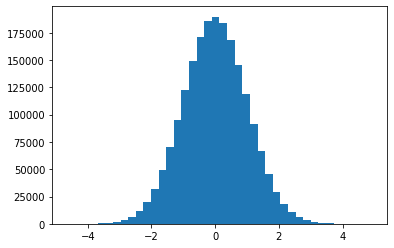

In [16]:
plt.hist(xi_3, bins = 40)
plt.show()

In [22]:
kstest ((xi_3 - np.mean(xi_3))/np.std(xi_3), 'norm')

KstestResult(statistic=0.0003930390381234883, pvalue=0.916707118186773)

/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
/content/blackscholes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


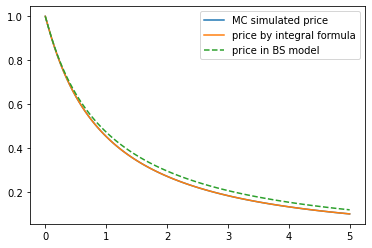

In [27]:
K = np.linspace (0, 5, 100)
mc_price = [np.mean (call_payoff (arr_3, k)) for k in K]
plt.plot (K, mc_price, label = 'MC simulated price')

integral_price = [pi_0 (a_3, k) for k in K]
plt.plot (K, integral_price, label = 'price by integral formula')

bs_prices = bs.call_price(s = 1.0, 
                          sigma = 0.4,  # sqrt(target_variance) == L * sqrt(theta)
                          t = 10, 
                          k = K, 
                          r = 0)
plt.plot (K, bs_prices, label = 'price in BS model', ls = '--')
plt.legend()
plt.show()